In [31]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)

from models import DeepConditionalModel
from inn_utils import train_loop_active
from process_models import simulate_ricker
from viz import plot_true_est_scatter, plot_true_est_posterior, plot_losses

In [13]:
tf.enable_eager_execution()

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Summary network for the Ricker model
<p>We use an LSTM for the observed time-series data.</p>

In [14]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=32, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(h_lstm_dim)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
        ])
    
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

# Initialization 

In [30]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [128, 128, 128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
param_names = ['r', 'sigma', 'phi']
theta_dim = 3
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 10
iterations_per_epoch = 10000
n_inv_blocks = 6
n_test = 300
n_samples_posterior = 2000
verbose_each = 100
starter_learning_rate = 0.0001
decay_steps = 5000
decay_rate = .9
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

## Create a test set

In [22]:
X_test, theta_test = simulate_ricker(n_test, t_obs_min=500, t_obs_max=500)

## Create networks and checkpoints

In [24]:
summary_net = SequenceNetwork(h_lstm_dim=64)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Plot performance of untrained model

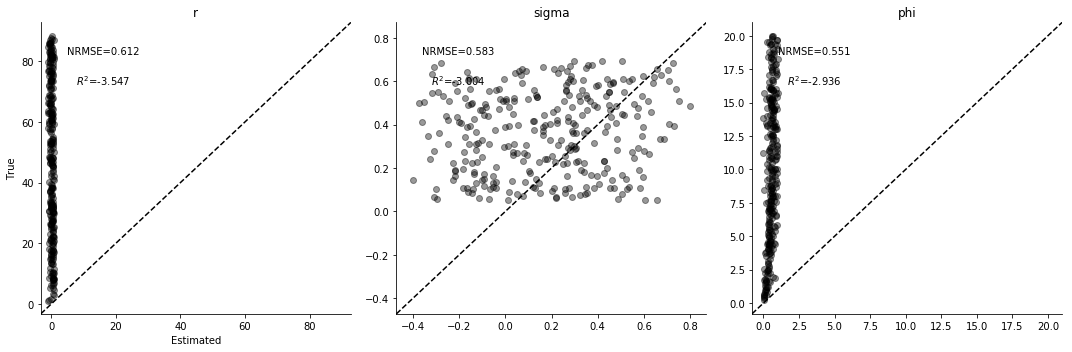

In [26]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(15, 5))

# Train the model

In [ ]:
for ep in range(1, epochs+1):
    with tqdm(total=iterations, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_loop(model, optimizer, simulate_ricker, iterations, batch_size, 
                            p_bar, clip_value=clip_value, global_step=global_step)
        plot_losses(losses)
        plot_

In [10]:
model.load_weights('models/permutation_50000')

In [11]:
model.variables

[<tf.Variable 'conditional_invertible_block/coupling_net/sequential_1/dense_2/kernel:0' shape=(66, 128) dtype=float32, numpy=
 array([[-0.06603377, -0.06830831, -0.10618254, ...,  0.28270888,
          0.28627676,  0.02924456],
        [ 0.00503238, -0.00390986,  0.0059848 , ...,  0.00699642,
          0.02520449, -0.00403414],
        [ 0.29694647, -0.2994434 ,  0.38019976, ..., -0.00120365,
          0.08554154, -0.08288521],
        ...,
        [ 0.0908974 ,  0.07506847,  0.14242359, ..., -0.12780406,
         -0.0273115 ,  0.0364591 ],
        [-0.05535174,  0.07976367,  0.15947348, ..., -0.07947955,
          0.14178786, -0.09933128],
        [-0.16159122,  0.3141615 , -0.03953097, ...,  0.38822052,
          0.15422326,  0.09470344]], dtype=float32)>,
 <tf.Variable 'conditional_invertible_block/coupling_net/sequential_1/dense_2/bias:0' shape=(128,) dtype=float32, numpy=
 array([-2.24123865e-01,  6.07841238e-02, -3.10209021e-02,  1.61735728e-01,
        -8.98044109e-02,  3.238055

In [ ]:
model.variables

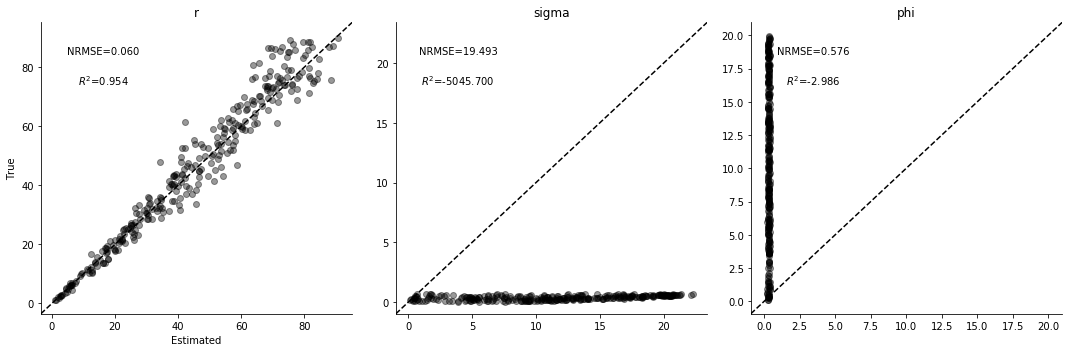

In [13]:
plot_true_est_scatter(model, X_test, theta_test, 5000, param_names, figsize=(15, 5))

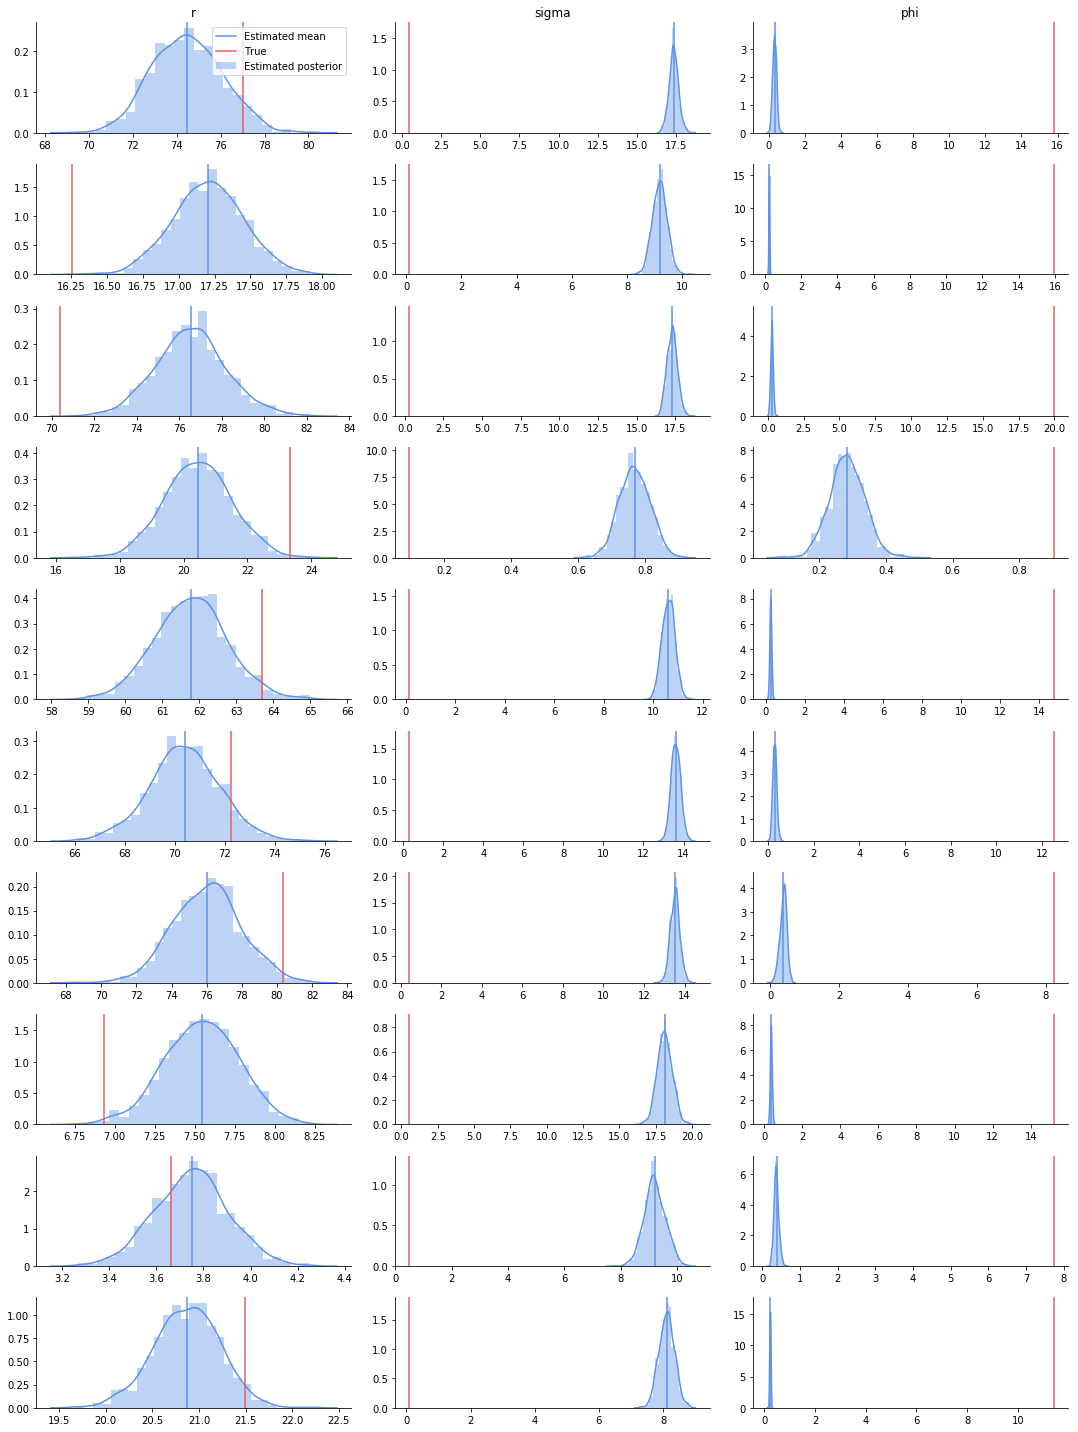

In [14]:
plot_true_est_posterior(model, n_samples=1000, param_names=param_names, 
                        n_test=10, data_generator=simulate_ricker)

In [ ]:
model.save_weights('models/ricker_permute')